In [1]:
#!/usr/bin/env python
# coding: utf-8

from __future__ import division

import numpy as np
import pandas as pd
import time
import os
import sys
import datetime
import pickle

import tensorflow as tf

import import_ipynb
from data_generators import mnist_generator
from utilities import plot_mnist_digits, create_adversarial_pattern

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

importing Jupyter notebook from data_generators.ipynb
importing Jupyter notebook from utilities.ipynb


In [2]:
# Set RNG seeds, for repeatability
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
fs_titles = 20 # font size for figure titles

# Load and display the training history of all the models

In [4]:
# Instantiate generator
null_types = None
batch_size = 10000

# Download the MNIST data located here: http://yann.lecun.com/exdb/mnist/
# and set dir_mnist to the location of your downloaded data:
dir_mnist = './mnist'
# dir_mnist = '/home/mroos/Data/pylearn2data/mnist'

gen_test = mnist_generator(dir_mnist, batch_size=batch_size, dataset='test',
                           random_order=False, null_types=null_types, p_null_class=0)

In [187]:
model_null_types = ['u', 's', 'us', 'm', 'um', 'sm', 'usm']
n_null_types = len(model_null_types)

# Create strings will full null type names, for plot titles, etc.
model_null_types_full_names = []
for mnt in model_null_types:
    names = []
    for c in mnt:
        if c=='u':
            names.append('uniform')
        if c=='s':
            names.append('shuffled')
        if c=='m':
            names.append('mixed')
    model_null_types_full_names.append(' + '.join(names))

# Determine how many sets of models we have, based on numbers at end filenames
dir_models = './saved_models_mnist_sets/'
filenames = os.listdir(dir_models)
filenames = [f for f in filenames if f.startswith('mnist_model_baseline_') ]
filenames = np.sort(filenames)
n_sets = int(filenames[-1][-5:-3])

Measuring accuracy for baseline model 30 of 31.
Measuring accuracy for u model 30 of 31.
Measuring accuracy for s model 30 of 31.
Measuring accuracy for us model 30 of 31.
Measuring accuracy for m model 30 of 31.
Measuring accuracy for um model 30 of 31.
Measuring accuracy for sm model 30 of 31.
Measuring accuracy for usm model 30 of 31.


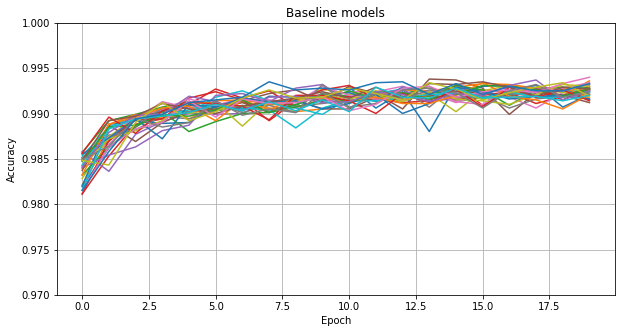

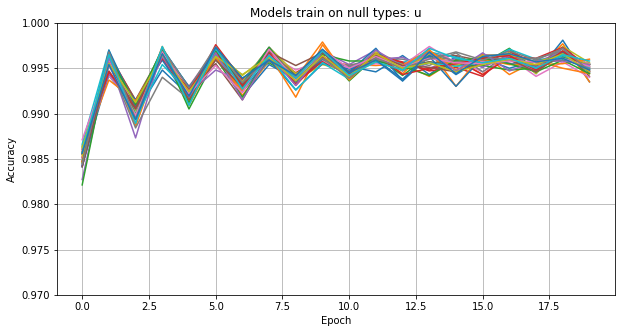

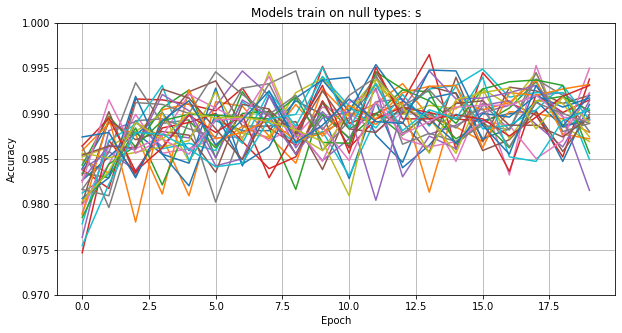

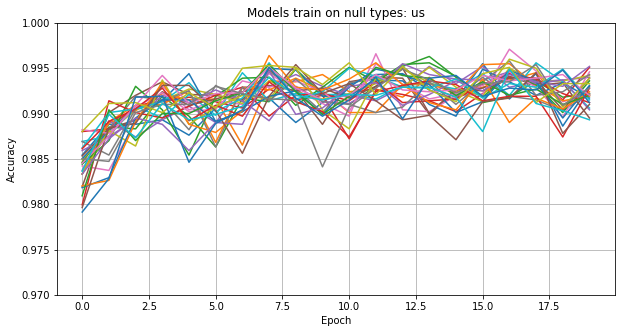

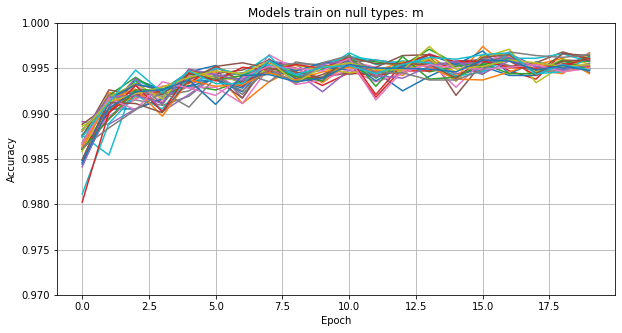

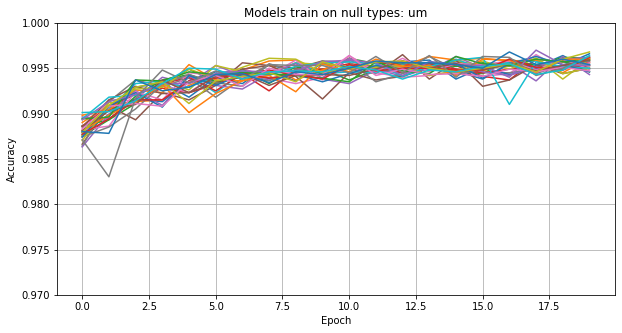

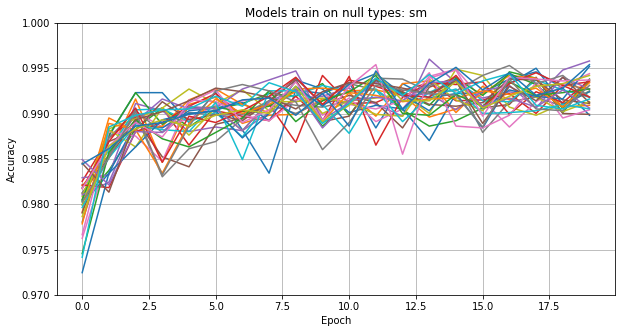

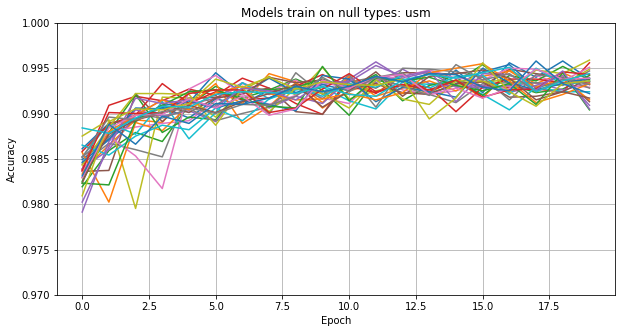

In [6]:
# Plot histories for the baseline models, and get test set scores
fig = plt.figure(figsize=(10, 5))
acc_baseline_models = np.zeros((n_sets))
for i_set in range(n_sets):
    history_filename = os.path.join(dir_models, 'mnist_model_history_baseline_%0.2d.pkl' % (i_set))
    history = pickle.load(open(history_filename,'rb'))
    plt.plot(history['val_sparse_categorical_accuracy'])

    notification = 'Measuring accuracy for baseline model %d of %d.' % (i_set, n_sets)
    sys.stdout.write('\r' + notification)
    sys.stdout.flush()
    
    model_filename = os.path.join(dir_models, 'mnist_model_baseline_%0.2d.h5' % (i_set))
    model = tf.keras.models.load_model(model_filename)
    images, labels, _ = next(gen_test)
    predictions = model(images)
    predictions = np.argmax(predictions, axis=1)
    n_correct = np.sum(predictions==labels)
    acc_baseline_models[i_set] = n_correct / 10000

print('')
plt.title('Baseline models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.97, 1.0])
plt.grid(True)

# Plot histories for the null-trained models, and get test set scores
acc_null_models = np.zeros((n_null_types, n_sets))
for i_null_types, null_types in enumerate(model_null_types):
    fig = plt.figure(figsize=(10, 5))
    for i_set in range(n_sets):
        history_filename = os.path.join(dir_models, 'mnist_model_history_%s_%0.2d.pkl' % (null_types, i_set))
        history = pickle.load(open(history_filename,'rb'))
        plt.plot(history['val_sparse_categorical_accuracy'])
        
        notification = 'Measuring accuracy for %s model %d of %d.' % (null_types, i_set, n_sets)
        sys.stdout.write('\r' + notification)
        sys.stdout.flush()
    
        model_filename = os.path.join(dir_models, 'mnist_model_%s_%0.2d.h5' % (null_types, i_set))
        model = tf.keras.models.load_model(model_filename)
        images, labels, _ = next(gen_test)
        predictions = model(images)
        predictions = np.argmax(predictions, axis=1)
        n_correct = np.sum(predictions==labels)
        acc_null_models[i_null_types, i_set] = n_correct / 10000
    print('')

    plt.title('Models train on null types: %s' % (null_types))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([.97, 1.0])
    plt.grid(True)

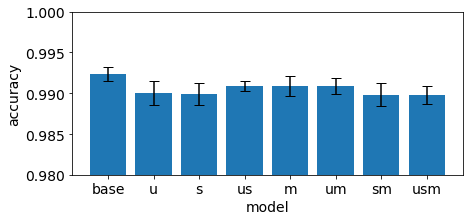

In [201]:
# Make barplot of test set accuracies, with error bars
acc_test_mean = np.mean(acc_baseline_models, keepdims=True)
acc_test_mean = np.concatenate((acc_test_mean, np.median(acc_null_models, axis=1)))
acc_test_std = np.std(acc_baseline_models, keepdims=True)
acc_test_std = np.concatenate((acc_test_std, np.std(acc_null_models, axis=1)))

print('Baseline mean accuracy: %0.2f%%' % (100*acc_test_mean[0]))

plt.figure(figsize=(7,3))
plt.bar(np.arange(n_null_types+1), acc_test_mean, yerr=acc_test_std, capsize=5)
plt.ylim([0.98, 1.0])
plt.xticks(np.arange(n_null_types+1))
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('model', fontsize=14)
ax = plt.gca()
ax.set_xticklabels(['base'] + model_null_types)
ax.tick_params(labelsize=14)

plt.savefig('figures/fig_test_set_scores.png', bbox_inches='tight')

# Run a loop over all the sets of models, and do the following:

1. Compute test set accuracy score for all models (not null images).
2. From the baseline model, create N=1000 adversarial images at threshold.
3. Store the epsilon thresholds (for creating histograms)
4. Run the image through all the models of the same set and record the number correct, misclassified, and unclassified.
5. For values of epsilon from 0 to 1, do the same as in 2, storing the results

# After that, create:
1. Table or plot of test set accuracy scores with std dev.
2. Histograms of epsilong thresholds (as a line, with min/max or 25 and 75%)
3. A barplot of scores at thresholds, with error bars.
4. A bunch of plots, one for each model type, showing scores versus epsilon, with shading for min/max
5. A set of plots like in 2, but overlaying results from baseline vs. s, baseline vs. s+u, and baseline vs. s+u+m

# Run the data generation loop

In [8]:
np.seterr(all='raise') # Raise an exception whenever there is a floating point error

null_types = None
batch_size = 1
gen_data = mnist_generator(dir_mnist, batch_size=batch_size, dataset='test',
                           random_order=False, null_types=null_types, p_null_class=0)

# Get range of epsilon values
step = 0.02
epsilons_dense = np.arange(0, 1+step, step)
n_epsilons = len(epsilons_dense)

n_adversarial = 1000

# Objects to store results
baseline_thresholds = []
threshold_scores = np.zeros((n_sets, n_null_types, 3))

null_correct_vs_eps = np.zeros((n_sets, n_null_types, n_epsilons))
null_unclass_vs_eps = np.zeros((n_sets, n_null_types, n_epsilons))
null_misclass_vs_eps = np.zeros((n_sets, n_null_types, n_epsilons))

baseline_correct_vs_eps = np.zeros((n_sets, n_epsilons))
baseline_unclass_vs_eps = np.zeros((n_sets, n_epsilons))
baseline_misclass_vs_eps = np.zeros((n_sets, n_epsilons))

    
## Loop over all sets...
for i_set in range(n_sets):
    model_filename_baseline = os.path.join(dir_models, 'mnist_model_baseline_%0.2d.h5' % (i_set))
    print('')
    print(datetime.datetime.now())
    print('Getting results for model set %d...' % (i_set))

    model_baseline = tf.keras.models.load_model(model_filename_baseline)

    ######################################################################
    ## Try to create adversarial images from source images. Repeat until
    ## enough of them are found.
    ######################################################################
    
    images_source = np.empty((n_adversarial, 784))
    labels_source = np.empty((n_adversarial, 1))
    grads_signed = np.empty((n_adversarial, 784))
    epsilon_thresholds = np.empty(n_adversarial)

    n_acquired = 0
    while n_acquired < n_adversarial:
        im, label, _ = next(gen_data)

        # If the model prediction is in error, don't use this image to create an adversarial image.
        outputs = model_baseline(im, training=False)
        predicted_labels = np.argmax(outputs, axis=1)
        if int(predicted_labels[0])!=label[0]:
            continue

        # Get the signed gradient that drives the source class towards a *higher* loss
        grad_signed, _ = create_adversarial_pattern(model_baseline,
                                                       tf.convert_to_tensor(im),
                                                       tf.convert_to_tensor(np.array(label)))

        # Create a series of images from the source image, in the direction of the negative gradient.
        eps_start = 1e-3
        eps_stop = 1.0
        epsilons = np.logspace(np.log10(eps_start), np.log10(eps_stop), num=9)
        epsilons = np.insert(epsilons, 0, 0)
        done_looking = False
        while not done_looking:
            perturbations = np.expand_dims(epsilons, axis=1) * grad_signed
            images = im + perturbations
            images = np.clip(images, 0, 1)
            outputs = model_baseline(images, training=False)
            predicted_labels = np.argmax(outputs, axis=1)

            ix_err = np.where(predicted_labels!=int(label[0]))[0]
            if ix_err.size==0:
                # No error for largest value in epsilon range. Start over on new source image.
                done_looking = True
            else:
                ix_first = ix_err[0]
                if ix_first==0:
                    raise Exception("This line of code should never be hit.")
                elif epsilons[ix_first]-epsilons[ix_first-1] <= 1e-3:
                    # Found threshold within desired tolerance
                    done_looking = True
                    epsilon_thresholds[n_acquired] = epsilons[ix_first]
                    grads_signed[n_acquired] = grad_signed
                    images_source[n_acquired] = im[0]
                    labels_source[n_acquired] = label[0]
                    n_acquired += 1
                    notification = '%d of %d adversarial images acquired.' % (n_acquired, n_adversarial)
                    sys.stdout.write('\r' + notification)
                    sys.stdout.flush()                
                else:
                    # Do it again, with tighter, denser epsilon range
                    epsilons = np.logspace(np.log10(epsilons[ix_first-1]), np.log10(epsilons[ix_first]), num=10)
    print('')

    baseline_thresholds.append(epsilon_thresholds)

    
    ######################################################################    
    ## Get scores from all null model types, at thresholds
    ######################################################################
    
    images_at_thresh = images_source + np.expand_dims(epsilon_thresholds, axis=1) * grads_signed
    images_at_thresh = np.clip(images_at_thresh, 0, 1)

    for i_null_type, null_types in enumerate(model_null_types):
        print('\tGetting threshold scores for model %s' % (null_types))
        model_filename = os.path.join(dir_models, 'mnist_model_%s_%0.2d.h5' % (null_types, i_set))
        model = tf.keras.models.load_model(model_filename)

        outputs = model(images_at_thresh, training=False)

        # Tally the number of errors of each type
        predictions = np.argmax(outputs, axis=1)
        n_correct = np.sum(labels_source[:,0]==predictions)
        n_unclass = np.sum(predictions==10)
        n_misclass = n_adversarial - n_correct - n_unclass
        threshold_scores[i_set, i_null_type, :] = np.array([n_correct, n_misclass, n_unclass])

    
    ######################################################################
    ## Get scores from all null model types, for range of epsilon values
    ######################################################################
    
    # Make set of images for each epsilon value
    adversarial_sets = []
    for eps in epsilons_dense:
        images_at_thresh = images_source + eps * grads_signed
        images_at_thresh = np.clip(images_at_thresh, 0, 1)
        adversarial_sets.append(images_at_thresh)

    # Score null models across all epsilon values
    for i_null_type, null_types in enumerate(model_null_types):
        print('\tGetting scores versus epsilon for model %s' % (null_types))
        model_filename = os.path.join(dir_models, 'mnist_model_%s_%0.2d.h5' % (null_types, i_set))
        model = tf.keras.models.load_model(model_filename)

        n_correct = np.zeros(n_epsilons, dtype=np.int)
        n_unclass = np.zeros(n_epsilons, dtype=np.int)
        for i_eps in range(n_epsilons):
            outputs = model(adversarial_sets[i_eps], training=False)
            predictions = np.argmax(outputs, axis=1)
            n_correct[i_eps] = np.sum(labels_source[:,0]==predictions)
            n_unclass[i_eps] = np.sum(predictions==10)

        null_correct_vs_eps[i_set, i_null_type, :] = n_correct
        null_unclass_vs_eps[i_set, i_null_type, :] = n_unclass
        null_misclass_vs_eps[i_set, i_null_type, :] = n_adversarial - n_correct - n_unclass
    
    
    ######################################################################
    ## Get scores from baseline model, for range of epsilon values
    ######################################################################
    print('\tGetting scores versus epsilon for baseline model.')
    model_filename = os.path.join(dir_models, 'mnist_model_baseline_%0.2d.h5' % (i_set))
    model = tf.keras.models.load_model(model_filename)

    n_correct = np.zeros(n_epsilons, dtype=np.int)
    n_unclass = np.zeros(n_epsilons, dtype=np.int)
    for i_eps in range(n_epsilons):
        outputs = model(adversarial_sets[i_eps], training=False)
        predictions = np.argmax(outputs, axis=1)
        n_correct[i_eps] = np.sum(labels_source[:,0]==predictions)
        n_unclass[i_eps] = np.sum(predictions==10)

    baseline_correct_vs_eps[i_set, :] = n_correct
    baseline_unclass_vs_eps[i_set, :] = n_unclass
    baseline_misclass_vs_eps[i_set, :] = n_adversarial - n_correct - n_unclass


2020-02-14 17:58:43.477844
Getting results for model set 0...
1000 of 1000 adversarial images acquired.
	Getting threshold scores for model u
	Getting threshold scores for model s
	Getting threshold scores for model us
	Getting threshold scores for model m
	Getting threshold scores for model um
	Getting threshold scores for model sm
	Getting threshold scores for model usm
	Getting scores versus epsilon for model u
	Getting scores versus epsilon for model s
	Getting scores versus epsilon for model us
	Getting scores versus epsilon for model m
	Getting scores versus epsilon for model um
	Getting scores versus epsilon for model sm
	Getting scores versus epsilon for model usm
	Getting scores versus epsilon for baseline model.

2020-02-14 18:00:09.004685
Getting results for model set 1...
1000 of 1000 adversarial images acquired.
	Getting threshold scores for model u
	Getting threshold scores for model s
	Getting threshold scores for model us
	Getting threshold scores for model m
	Getting 

	Getting threshold scores for model s
	Getting threshold scores for model us
	Getting threshold scores for model m
	Getting threshold scores for model um
	Getting threshold scores for model sm
	Getting threshold scores for model usm
	Getting scores versus epsilon for model u
	Getting scores versus epsilon for model s
	Getting scores versus epsilon for model us
	Getting scores versus epsilon for model m
	Getting scores versus epsilon for model um
	Getting scores versus epsilon for model sm
	Getting scores versus epsilon for model usm
	Getting scores versus epsilon for baseline model.

2020-02-14 18:15:46.666860
Getting results for model set 12...
1000 of 1000 adversarial images acquired.
	Getting threshold scores for model u
	Getting threshold scores for model s
	Getting threshold scores for model us
	Getting threshold scores for model m
	Getting threshold scores for model um
	Getting threshold scores for model sm
	Getting threshold scores for model usm
	Getting scores versus epsilon fo

	Getting threshold scores for model sm
	Getting threshold scores for model usm
	Getting scores versus epsilon for model u
	Getting scores versus epsilon for model s
	Getting scores versus epsilon for model us
	Getting scores versus epsilon for model m
	Getting scores versus epsilon for model um
	Getting scores versus epsilon for model sm
	Getting scores versus epsilon for model usm
	Getting scores versus epsilon for baseline model.

2020-02-14 18:31:35.470830
Getting results for model set 23...
1000 of 1000 adversarial images acquired.
	Getting threshold scores for model u
	Getting threshold scores for model s
	Getting threshold scores for model us
	Getting threshold scores for model m
	Getting threshold scores for model um
	Getting threshold scores for model sm
	Getting threshold scores for model usm
	Getting scores versus epsilon for model u
	Getting scores versus epsilon for model s
	Getting scores versus epsilon for model us
	Getting scores versus epsilon for model m
	Getting score

# Plot epsilon thresholds histogram

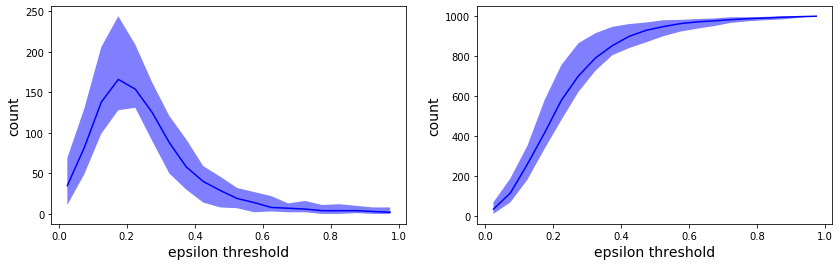

In [221]:
# Threshold histograms

n_bins = 20
histograms = np.zeros((n_sets, n_bins))
for i_set in range(n_sets):
    counts, edges = np.histogram(baseline_thresholds[i_set], n_bins, range=[0, 1])
    histograms[i_set,:] = counts

histmin = np.amin(histograms, axis=0)
histmax = np.amax(histograms, axis=0)
histmedian = np.median(histograms, axis=0)
centers = (edges[:-1] + edges[1:])/2

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)

plt.fill_between(centers, histmin, histmax, facecolor='blue', alpha=0.5)
_ = plt.plot(centers, histmedian, 'b-')
plt.xlabel('epsilon threshold', fontsize=14)
plt.ylabel('count', fontsize=14)
# plt.savefig('figures/fig_epsilon_thresholds_hist.png', bbox_inches='tight')

cdfs = np.cumsum(histograms, axis=1)
cdfmin = np.amin(cdfs, axis=0)
cdfmax = np.amax(cdfs, axis=0)
cdfmedian = np.median(cdfs, axis=0)

# plt.figure()
plt.subplot(1, 2, 2)
plt.fill_between(centers, cdfmin, cdfmax, facecolor='blue', alpha=0.5)
_ = plt.plot(centers, cdfmedian, 'b-')
plt.xlabel('epsilon threshold', fontsize=14)
plt.ylabel('count', fontsize=14)

plt.savefig('figures/fig_epsilon_thresholds_hist_cdf.png', bbox_inches='tight')

# Plot accuracy scores for adversarial images at threshold

             Correct  Misclassified   Unclassified
Model                                             
base     0.0 ±  0.0   100.0 ±  0.0     0.0 ±  0.0 
u       78.8 ±  7.6    19.1 ±  8.5     2.0 ±  3.4 
s       60.0 ± 12.5     9.7 ±  7.3    30.3 ±  9.9 
us      54.4 ± 15.6     9.5 ±  5.2    36.1 ± 17.7 
m        4.3 ±  1.6     3.0 ±  1.2    92.7 ±  2.1 
um       5.2 ±  2.5     2.6 ±  1.1    92.2 ±  3.2 
sm       7.8 ±  4.9     1.3 ±  1.0    90.9 ±  5.6 
usm      7.2 ±  5.9     1.2 ±  1.2    91.7 ±  6.9 


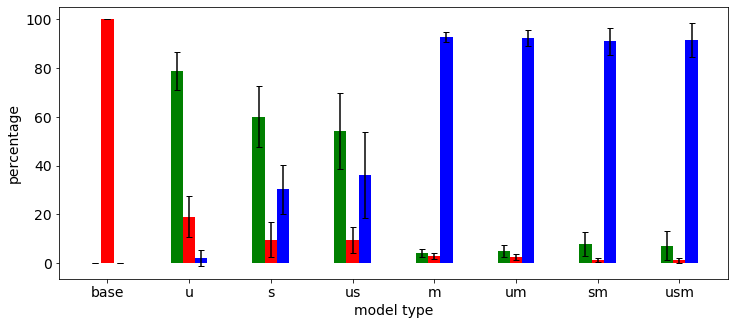

In [199]:
# Barplot of scores *at threshold*

threshold_scores_mean = np.mean(threshold_scores, axis=0) / n_adversarial * 100
threshold_scores_std = np.std(threshold_scores, axis=0) / n_adversarial * 100

# Add scores for baseline model, which are 100% misclassifieds by definition
threshold_scores_mean = np.concatenate((np.array([[0, 100, 0]]), threshold_scores_mean), axis=0)
threshold_scores_std = np.concatenate((np.array([[0, 0, 0]]), threshold_scores_std), axis=0)

x = np.arange(n_null_types+1)
fig = plt.figure(figsize=(12, 5))
plt.bar(x-0.15, threshold_scores_mean[:, 0], yerr=threshold_scores_std[:, 0], capsize=3, color = 'g', width = 0.15)
plt.bar(x+0.00, threshold_scores_mean[:, 1], yerr=threshold_scores_std[:, 1], capsize=3, color = 'r', width = 0.15)
plt.bar(x+0.15, threshold_scores_mean[:, 2], yerr=threshold_scores_std[:, 2], capsize=3, color = 'b', width = 0.15)

plt.ylabel('percentage', fontsize=14)
plt.xticks(np.arange(n_null_types+1))
plt.xlabel('model type', fontsize=14)
ax = plt.gca()
ax.set_xticklabels(['base'] + model_null_types)
ax.tick_params(labelsize=14)

# _ = plt.legend(['correct', 'misclassified', 'unclassified'], fontsize=12)
plt.savefig('figures/fig_scores_at_threshold.png', bbox_inches='tight')

# Create a table and print it out
n = threshold_scores_mean.size
threshold_scores_str = np.array(['{:5.1f} \u00B1 {:4.1f} '.format(m, s) for m, s in zip(threshold_scores_mean.reshape(n), threshold_scores_std.reshape(n))])
threshold_scores_str = threshold_scores_str.reshape(threshold_scores_mean.shape)

df_scores = pd.DataFrame(threshold_scores_str, columns=['Correct', 'Misclassified', 'Unclassified'])
d = {i+1:model_null_types[i] for i in range(n_null_types)}
d[0] = 'base' 
df_scores = df_scores.rename(index=d)
df_scores.index.name = 'Model'
df_scores.to_csv('figures/table_scores.csv')
print(df_scores)

# Plot accuracy scores as functions of epsilon

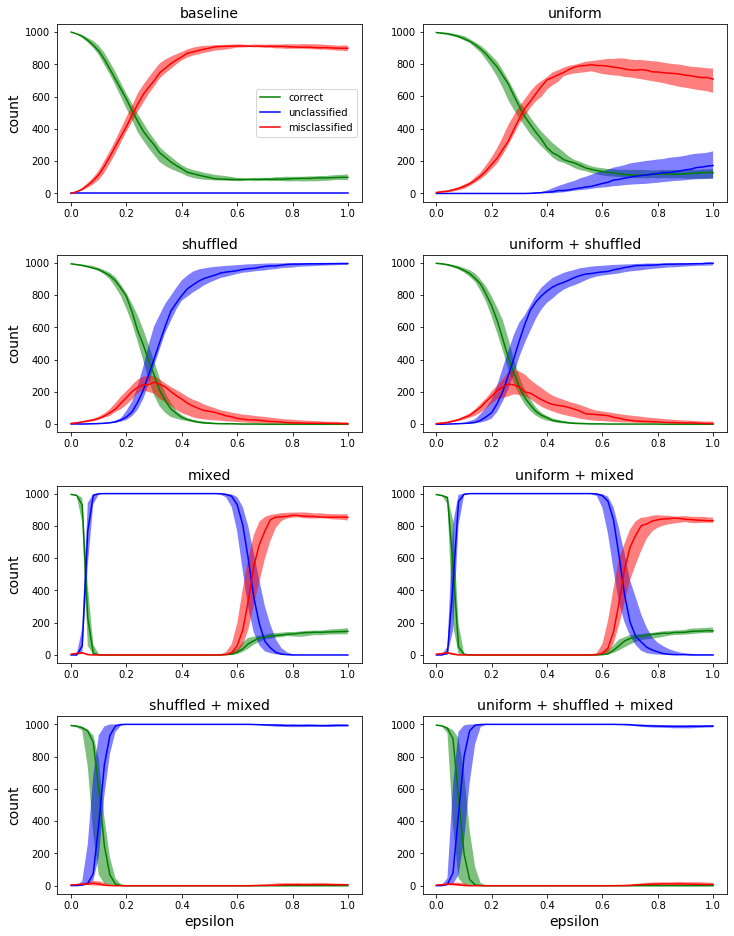

In [194]:
correct_median = np.median(baseline_correct_vs_eps, axis=0)
unclass_median = np.median(baseline_unclass_vs_eps, axis=0)
misclass_median = np.median(baseline_misclass_vs_eps, axis=0)
correct_low = np.percentile(baseline_correct_vs_eps, 25, axis=0)
unclass_low = np.percentile(baseline_unclass_vs_eps, 25, axis=0)
misclass_low = np.percentile(baseline_misclass_vs_eps, 25, axis=0)
correct_high = np.percentile(baseline_correct_vs_eps, 75, axis=0)
unclass_high = np.percentile(baseline_unclass_vs_eps, 75, axis=0)
misclass_high = np.percentile(baseline_misclass_vs_eps, 75, axis=0)

fig = plt.figure(figsize=(12, 16))
plt.subplot(4, 2, 1)

plt.fill_between(epsilons_dense, correct_low, correct_high, facecolor='green', alpha=0.5)
handle_correct = plt.plot(epsilons_dense, correct_median, 'g')

plt.fill_between(epsilons_dense, unclass_low, unclass_high, facecolor='blue', alpha=0.5)
handle_unclass = plt.plot(epsilons_dense, unclass_median, 'b')

plt.fill_between(epsilons_dense, misclass_low, misclass_high, facecolor='red', alpha=0.5)
handle_misclass = plt.plot(epsilons_dense, misclass_median, 'r')

plt.ylabel('count', fontsize=14)
plt.legend(handle_correct + handle_unclass + handle_misclass, ('correct', 'unclassified', 'misclassified'))
plt.title('baseline', fontsize=14)


for i_null_types in range(n_null_types):
    correct_median = np.median(null_correct_vs_eps[:,i_null_types,:], axis=0)
    unclass_median = np.median(null_unclass_vs_eps[:,i_null_types,:], axis=0)
    misclass_median = np.median(null_misclass_vs_eps[:,i_null_types,:], axis=0)
    correct_low = np.percentile(null_correct_vs_eps[:,i_null_types,:], 25, axis=0)
    unclass_low = np.percentile(null_unclass_vs_eps[:,i_null_types,:], 25, axis=0)
    misclass_low = np.percentile(null_misclass_vs_eps[:,i_null_types,:], 25, axis=0)
    correct_high = np.percentile(null_correct_vs_eps[:,i_null_types,:], 75, axis=0)
    unclass_high = np.percentile(null_unclass_vs_eps[:,i_null_types,:], 75, axis=0)
    misclass_high = np.percentile(null_misclass_vs_eps[:,i_null_types,:], 75, axis=0)
    
    plt.subplot(4, 2, i_null_types+2)

    plt.fill_between(epsilons_dense, correct_low, correct_high, facecolor='green', alpha=0.5)
    handle_correct = plt.plot(epsilons_dense, correct_median, 'g')

    plt.fill_between(epsilons_dense, unclass_low, unclass_high, facecolor='blue', alpha=0.5)
    handle_unclass = plt.plot(epsilons_dense, unclass_median, 'b')
    
    plt.fill_between(epsilons_dense, misclass_low, misclass_high, facecolor='red', alpha=0.5)
    handle_misclass = plt.plot(epsilons_dense, misclass_median, 'r')
    
    if i_null_types%2==1:
        plt.ylabel('count', fontsize=14)
    if i_null_types > n_null_types-3:
        plt.xlabel('epsilon', fontsize=14)
    # plt.title('%s' % (model_null_types[i_null_types]), fontsize=14)
    plt.title('%s' % (model_null_types_full_names[i_null_types]), fontsize=14)

plt.subplots_adjust(hspace=0.3)

plt.savefig('figures/fig_scores_versus_epsilon.png', bbox_inches='tight')

# Plot accuracy comparison of baseline model to three null models

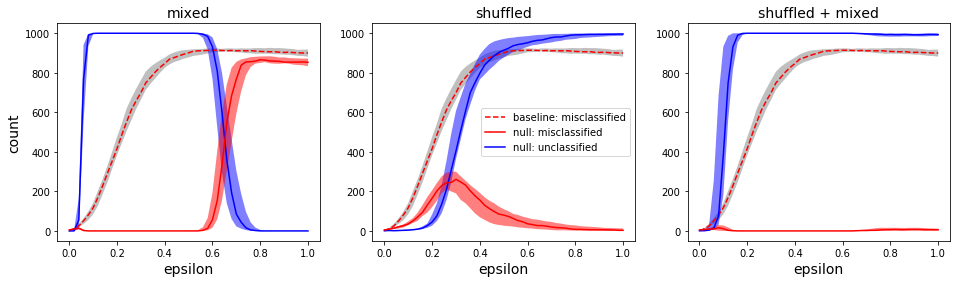

In [216]:
comparison_types = ['m', 's', 'sm']
ix_null_types = [model_null_types.index(ct) for ct in comparison_types]

base_correct_median = np.median(baseline_correct_vs_eps, axis=0)
base_unclass_median = np.median(baseline_unclass_vs_eps, axis=0)
base_misclass_median = np.median(baseline_misclass_vs_eps, axis=0)
base_correct_low = np.percentile(baseline_correct_vs_eps, 25, axis=0)
base_unclass_low = np.percentile(baseline_unclass_vs_eps, 25, axis=0)
base_misclass_low = np.percentile(baseline_misclass_vs_eps, 25, axis=0)
base_correct_high = np.percentile(baseline_correct_vs_eps, 75, axis=0)
base_unclass_high = np.percentile(baseline_unclass_vs_eps, 75, axis=0)
base_misclass_high = np.percentile(baseline_misclass_vs_eps, 75, axis=0)

fig = plt.figure(figsize=(16, 4))

for cnt, i_null_types in enumerate(ix_null_types):
    correct_median = np.median(null_correct_vs_eps[:,i_null_types,:], axis=0)
    unclass_median = np.median(null_unclass_vs_eps[:,i_null_types,:], axis=0)
    misclass_median = np.median(null_misclass_vs_eps[:,i_null_types,:], axis=0)
    correct_low = np.percentile(null_correct_vs_eps[:,i_null_types,:], 25, axis=0)
    unclass_low = np.percentile(null_unclass_vs_eps[:,i_null_types,:], 25, axis=0)
    misclass_low = np.percentile(null_misclass_vs_eps[:,i_null_types,:], 25, axis=0)
    correct_high = np.percentile(null_correct_vs_eps[:,i_null_types,:], 75, axis=0)
    unclass_high = np.percentile(null_unclass_vs_eps[:,i_null_types,:], 75, axis=0)
    misclass_high = np.percentile(null_misclass_vs_eps[:,i_null_types,:], 75, axis=0)

    plt.subplot(1, 3, cnt+1)
    
#     plt.fill_between(epsilons_dense, base_correct_low, base_correct_high, facecolor='gray', alpha=0.5)
#     handle_base_correct = plt.plot(epsilons_dense, base_correct_median, 'g--')
    
    plt.fill_between(epsilons_dense, base_misclass_low, base_misclass_high, facecolor='gray', alpha=0.5)
    handle_base_misclass = plt.plot(epsilons_dense, base_misclass_median, 'r--')
    
#     plt.fill_between(epsilons_dense, correct_low, correct_high, facecolor='green', alpha=0.5)
#     handle_correct = plt.plot(epsilons_dense, correct_median, 'g')
    
    plt.fill_between(epsilons_dense, unclass_low, unclass_high, facecolor='blue', alpha=0.5)
    handle_unclass = plt.plot(epsilons_dense, unclass_median, 'b')

    plt.fill_between(epsilons_dense, misclass_low, misclass_high, facecolor='red', alpha=0.5)
    handle_misclass = plt.plot(epsilons_dense, misclass_median, 'r')    

    if cnt==0:
        plt.ylabel('count', fontsize=14)
    if cnt==1:
#         plt.legend(handle_base_correct + handle_base_misclass + handle_correct + handle_misclass+ handle_unclass,
#                    ('baseline: correct', 'baseline: misclassified',
#                     'null: correct', 'null: misclassified', 'null: unclassified'))
        plt.legend(handle_base_misclass + handle_misclass + handle_unclass,
                   ('baseline: misclassified', 'null: misclassified', 'null: unclassified'))
    plt.title('%s' % model_null_types_full_names[i_null_types], fontsize=14)
    plt.xlabel('epsilon', fontsize=14)
    
plt.savefig('figures/fig_scores_versus_epsilon_model_compare.png', bbox_inches='tight')